<a href="https://colab.research.google.com/github/AnusreeChittineni/VAIL_2021/blob/main/Cats_vs_Dogs_ImgClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup & Importation

In [16]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
# downloads raw data and unzips file
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
#!unzip -q kagglecatsanddogs_3367a.zip
#!ls

In [17]:
!ls PetImages

Cat  Dog


In [18]:
# filter out corrupted images
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


### Generate a Dataset

In [22]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


### Visualize the Data

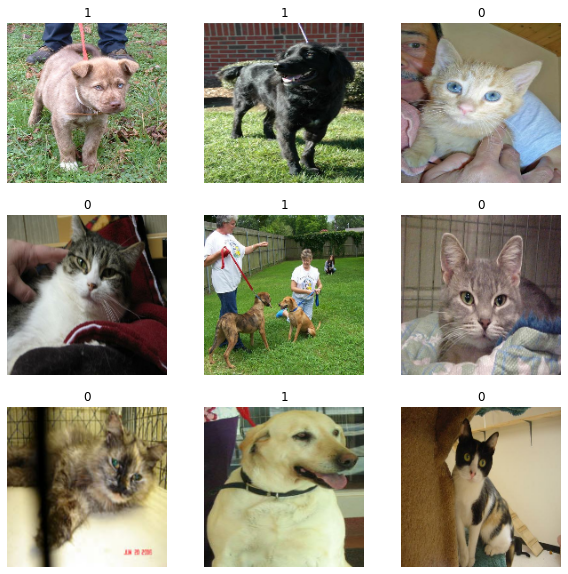

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data Augmentation

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

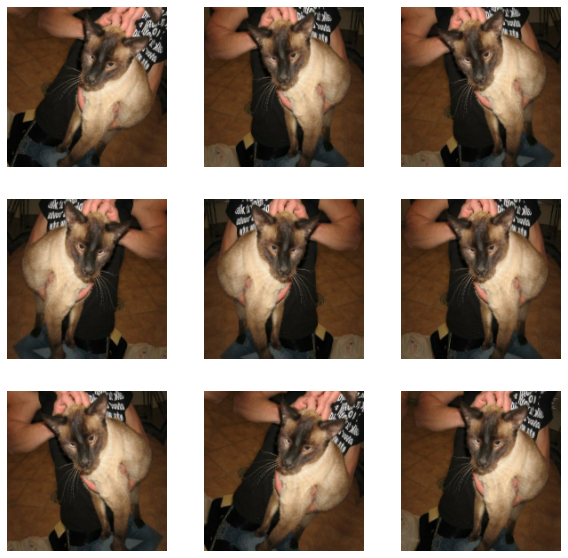

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Standardizing the data

In [26]:
### Option 1: make it part of the model (preferred when on GPU) ###
#inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = layers.experimental.preprocessing.Rescaling(1./255)(x)

### Option 2: apply it to the datasheet (preferred when on CPU) ###
#augmented_train_ds = train_ds.map(
#  lambda x, y: (data_augmentation(x, training=True), y))

### Dataset Configuration for performance

In [27]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Building Model

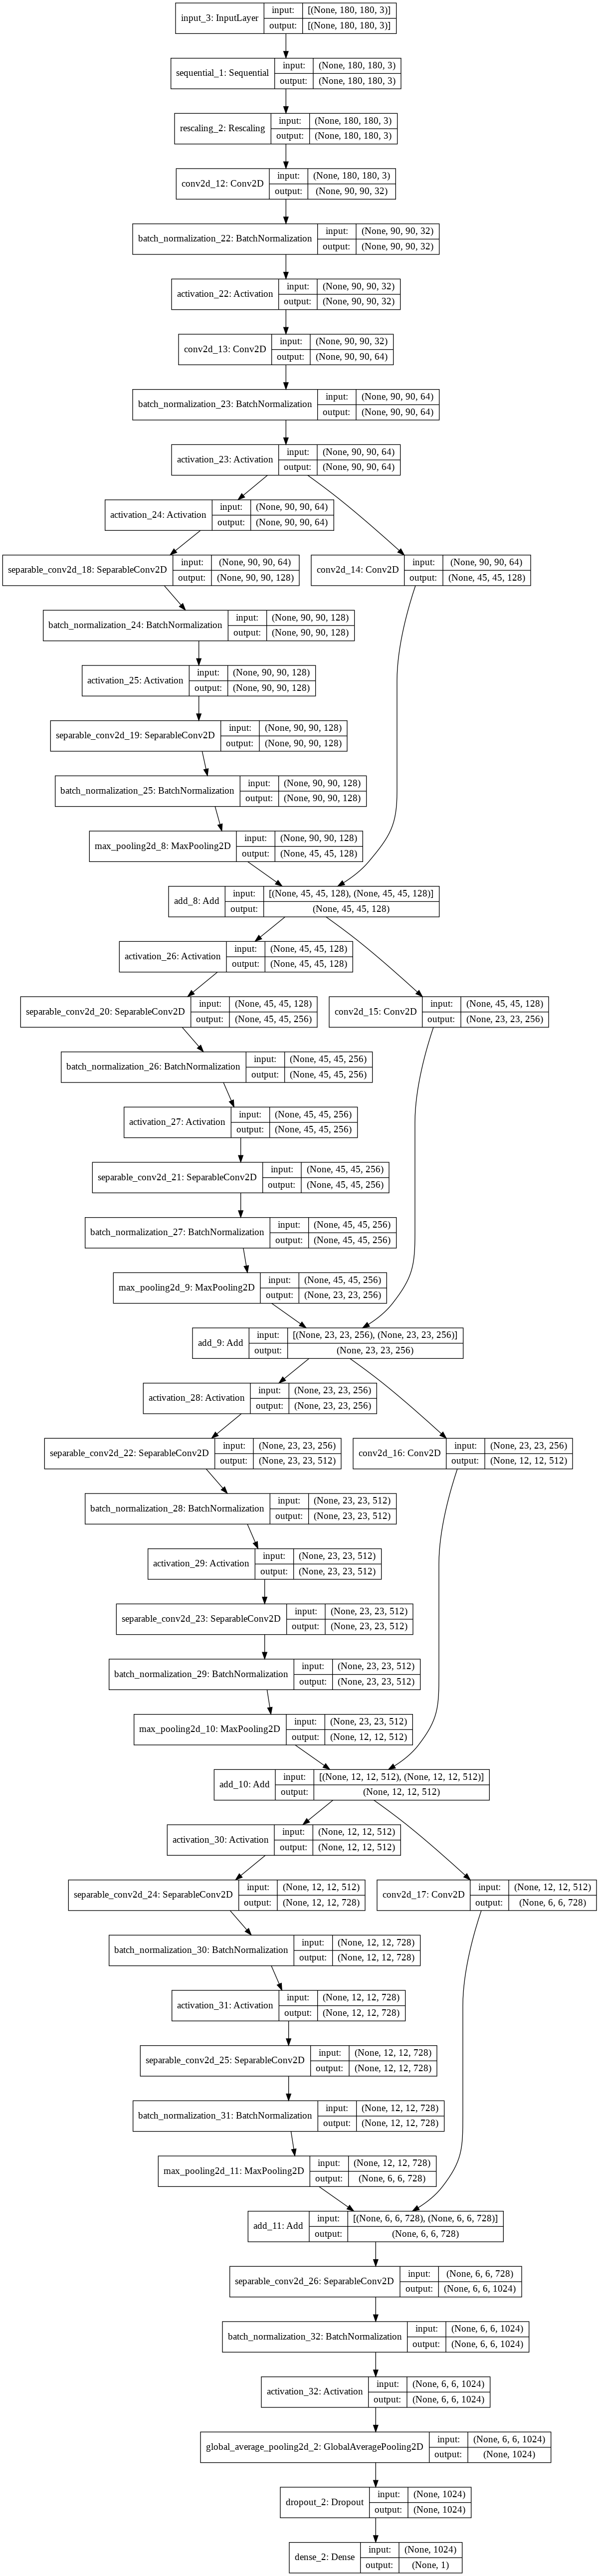

In [28]:
def make_model(input_shape, num_classes):
  
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

### Training the Model

In [34]:
# reduced epoch number so model would train faster
# took around 2:30 mins per epoch...why so long?
epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, batch_size = 64)

Epoch 1/10
586/586 [==============================] - 156s 262ms/step - loss: 0.1544 - accuracy: 0.9353 - val_loss: 0.1922 - val_accuracy: 0.9231
Epoch 2/10
586/586 [==============================] - 154s 263ms/step - loss: 0.1480 - accuracy: 0.9394 - val_loss: 0.1557 - val_accuracy: 0.9357
Epoch 3/10
586/586 [==============================] - 154s 262ms/step - loss: 0.1463 - accuracy: 0.9423 - val_loss: 0.3007 - val_accuracy: 0.8917
Epoch 4/10
586/586 [==============================] - 154s 263ms/step - loss: 0.1370 - accuracy: 0.9446 - val_loss: 0.1369 - val_accuracy: 0.9513
Epoch 5/10
586/586 [==============================] - 154s 262ms/step - loss: 0.1279 - accuracy: 0.9487 - val_loss: 0.2185 - val_accuracy: 0.9073
Epoch 6/10
586/586 [==============================] - 154s 261ms/step - loss: 0.1205 - accuracy: 0.9509 - val_loss: 0.1085 - val_accuracy: 0.9577
Epoch 7/10
586/586 [==============================] - 154s 262ms/step - loss: 0.1354 - accuracy: 0.9455 - val_loss: 0.1356 -

### Testing the Model

In [38]:
# MODEL OVERFIT

img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Note that data augmentation and dropout are inactive at inference time.
print(img)
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

<PIL.Image.Image image mode=RGB size=180x180 at 0x7FA5B34384A8>
This image is 24.90 percent cat and 75.10 percent dog.
